## HMMs and Viterbi algorithm for POS tagging

### Data Preparation

In [172]:
#Importing libraries
import numpy as np 
import pandas as pd
import nltk, re
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import sent_tokenize,word_tokenize
from collections import Counter

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
nltk_data[:5]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [4]:
print('No of sentence in nltk universal dataset',len(nltk_data))

No of sentence in universal dataset 3914


### Building the vanilla Viterbi based POS tagger

In [171]:
#Splitting the data set into train and validation set into 95:5
train,validation = train_test_split(nltk_data,train_size=0.95,random_state=1234)
#Training data set
train[:1]

[[('This', 'DET'),
  ('year', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('average', 'NOUN'),
  ('of', 'ADP'),
  ('daily', 'ADJ'),
  ('contracts', 'NOUN'),
  ('traded', 'VERB'),
  ('*', 'X'),
  ('totaled', 'VERB'),
  ('9,118', 'NUM'),
  (',', '.'),
  ('up', 'ADP'),
  ('from', 'ADP'),
  ('4,645', 'NUM'),
  ('a', 'DET'),
  ('year', 'NOUN'),
  ('earlier', 'ADJ'),
  ('and', 'CONJ'),
  ('from', 'ADP'),
  ('917', 'NUM'),
  ('in', 'ADP'),
  ('1984', 'NUM'),
  ('.', '.')]]

In [6]:
print('No of sentence in training data set',len(train))
print('No of sentence in validation data set',len(validation))

No of sentence in training data set 3718
No of sentence in validation data set 196


In [26]:
#List of Tagged words in training set
word_tag = [tup for li in train for tup in li]
print(len(word_tag))
print(word_tag[:7])

95799
[('This', 'DET'), ('year', 'NOUN'), (',', '.'), ('the', 'DET'), ('average', 'NOUN'), ('of', 'ADP'), ('daily', 'ADJ')]


In [27]:
#tokens
tokens = [word[0] for word in word_tag]
tokens[:10]

['This',
 'year',
 ',',
 'the',
 'average',
 'of',
 'daily',
 'contracts',
 'traded',
 '*']

In [28]:
#vocab
vocab = list(set(tokens))
len(vocab)
#sorted(vocab)[-10:]

12073

In [29]:
#No of unique tags
tags = [word[1] for word in word_tag]
tags=list(set(tags))
print('No of unique tags',len(tags))
print(tags)

No of unique tags 12
['ADP', '.', 'PRON', 'ADJ', 'X', 'CONJ', 'PRT', 'NUM', 'ADV', 'VERB', 'NOUN', 'DET']


Emission Probability

In [30]:
def emission(word,tag,train_bag=word_tag):
    tag_list = [tags for tags in train_bag if tags[1]==tag]
    count_tag = len(tag_list)
    word_with_tag = [tags for tags in tag_list if word==tags[0]]
    count_w_with_tag = len(word_with_tag)
    return (count_w_with_tag,count_tag)

In [31]:
emission('The','DET')

(683, 8269)

Transition Probability 

In [32]:
def transition(tag2,tag1,train_bag=word_tag):
    tag_list = [tags[1] for tags in train_bag]# total No of tags
    count_t1 = len([tag for tag in tag_list if tag==tag1])# Tags from t1 to t2
    count_t1_t2=0
    for i in range(len(tag_list)-1):
        if tag_list[i]==tag1 and tag_list[i+1]==tag2:
            count_t1_t2+=1
    return (count_t1_t2,count_t1)

In [33]:
transition('DET','.')

(1928, 11130)

In [34]:
#Creating the size of transition matrix
trans_matrix=np.zeros([len(tags),len(tags)],dtype=float)
trans_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [45]:
#calculating the values for transition matrix
for i in range(len(tags)):
    for j in range(len(tags)):
        trans_matrix[i][j] = transition(tags[j],tags[i])[0]/transition(tags[j],tags[i])[1]
trans_matrix

array([[1.65121977e-02, 3.98423351e-02, 7.02034729e-02, 1.05784596e-01,
        3.50484713e-02, 9.58772771e-04, 1.49142431e-03, 6.20006392e-02,
        1.38489400e-02, 8.52242463e-03, 3.22893363e-01, 3.22893363e-01],
       [9.03863432e-02, 9.40700809e-02, 6.57681941e-02, 4.46540881e-02,
        2.73135669e-02, 5.77717880e-02, 2.33602875e-03, 8.05929919e-02,
        5.19317161e-02, 8.87690925e-02, 2.23090746e-01, 1.73225517e-01],
       [2.32913326e-02, 4.04734632e-02, 7.63650248e-03, 7.36922489e-02,
        9.39289805e-02, 4.58190149e-03, 1.18365788e-02, 7.25467736e-03,
        3.28369607e-02, 4.87972509e-01, 2.07331042e-01, 9.16380298e-03],
       [7.75193798e-02, 6.58090054e-02, 6.59739403e-04, 6.53142009e-02,
        2.14415306e-02, 1.66584199e-02, 1.08857001e-02, 2.11116609e-02,
        4.94804552e-03, 1.22051790e-02, 6.98499093e-01, 4.94804552e-03],
       [1.44936709e-01, 1.62816456e-01, 5.63291139e-02, 1.64556962e-02,
        7.48417722e-02, 1.07594937e-02, 1.84651899e-01, 2.68

In [46]:
#Maling dataframe of transition matrix
tags_df = pd.DataFrame(trans_matrix,columns=tags,index=tags)
tags_df

,ADP,.,PRON,ADJ,X,CONJ,PRT,NUM,ADV,VERB,NOUN,DET
ADP,0.016512,0.039842,0.070203,0.105785,0.035048,0.000959,0.001491,0.062001,0.013849,0.008522,0.322893,0.322893
.,0.090386,0.094070,0.065768,0.044654,0.027314,0.057772,0.002336,0.080593,0.051932,0.088769,0.223091,0.173226
PRON,0.023291,0.040473,0.007637,0.073692,0.093929,0.004582,0.011837,0.007255,0.032837,0.487973,0.207331,0.009164
ADJ,0.077519,0.065809,0.000660,0.065314,0.021442,0.016658,0.010886,0.021112,0.004948,0.012205,0.698499,0.004948
X,0.144937,0.162816,0.056329,0.016456,0.074842,0.010759,0.184652,0.002690,0.026108,0.204114,0.062184,0.054114
CONJ,0.052705,0.033116,0.057369,0.118937,0.008862,0.000466,0.005131,0.041511,0.055970,0.158582,0.348881,0.118470
PRT,0.021173,0.041694,0.017915,0.084039,0.014007,0.002280,0.001954,0.056678,0.009772,0.402932,0.247883,0.099674
NUM,0.035672,0.115933,0.001486,0.032402,0.210464,0.013377,0.027051,0.184899,0.002973,0.018133,0.354637,0.002973
ADV,0.118611,0.134666,0.015400,0.129751,0.023263,0.006881,0.014744,0.031455,0.081258,0.344364,0.031127,0.068480
VERB,0.091402,0.035167,0.035321,0.065221,0.217816,0.005577,0.031216,0.022696,0.083501,0.167622,0.110844,0.133617


In [57]:
tags_df.loc['DET','NOUN']

0.6386503809408635

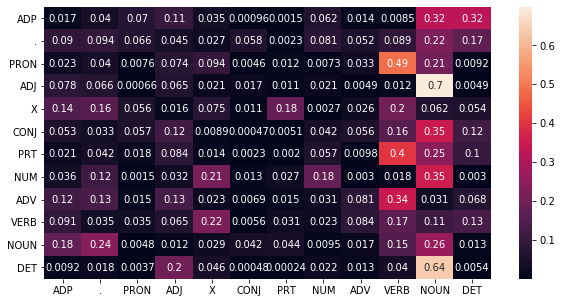

In [48]:
plt.figure(figsize=[10,5])
sns.heatmap(tags_df,annot=True)

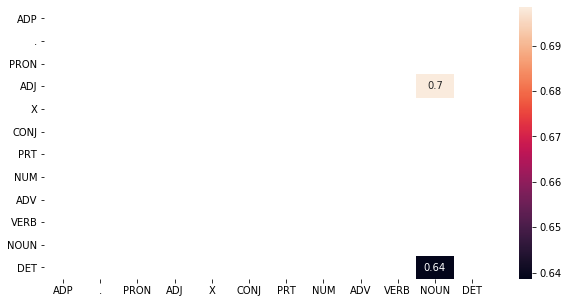

In [49]:
plt.figure(figsize=[10,5])
sns.heatmap(tags_df[tags_df>0.5],annot=True)

Probability of transition to NOUN from a determinant and adjective is high which is a general observation

Viterbi algorithm:

In [98]:
def viterbi(words,train_bag=word_tag):
    tags=list(set([pair[1] for pair in word_tag]))
    state=[]
    for key,word in enumerate(words):
        prob = []
        for t in tags:
            if key==0:
                trans_p = tags_df.loc['.',t]
            else:
                trans_p = tags_df.loc[state[-1],t]
            emit_p = emission(word,t)[0]/emission(word,t)[1]
            state_p = trans_p*emit_p
            prob.append(state_p)
        state.append(tags[prob.index(max(prob))])
    return list(zip(words,state))

Validation set 

In [101]:
#Pair of word and tags in the validation set
validation_word_tag = [word for sentence in validation for word in sentence]
validation_word_tag[:10]

[('Ruth', 'NOUN'),
 ('K.', 'NOUN'),
 ('Nelson', 'NOUN'),
 ('Cullowhee', 'NOUN'),
 (',', '.'),
 ('N.C', 'NOUN'),
 ('.', '.'),
 ('Among', 'ADP'),
 ('other', 'ADJ'),
 ('Connecticut', 'NOUN')]

In [102]:
#Words in the validation tag
validation_words= [word[0] for word in validation_word_tag]
validation_words[:6]

['Ruth', 'K.', 'Nelson', 'Cullowhee', ',', 'N.C']

In [103]:
test_sequence1=viterbi(validation_words)
test_sequence1[:10]

[('Ruth', 'ADP'),
 ('K.', 'NOUN'),
 ('Nelson', 'NOUN'),
 ('Cullowhee', 'ADP'),
 (',', '.'),
 ('N.C', 'NOUN'),
 ('.', '.'),
 ('Among', 'ADP'),
 ('other', 'ADJ'),
 ('Connecticut', 'NOUN')]

It can be observed that unknown words are tagged by ADP which is affecting the accuracy 

In [209]:
correct=[j for i,j in zip(validation_word_tag,test_sequence1) if i==j]#correctly tagged words
len(correct)

4423

In [210]:
accuracy_viterbi=len(correct)/len(validation_word_tag)#accuracy of vanilla viterbi
accuracy_viterbi

0.906909985646914

In [168]:
#Incorrect tagged words by vanilla viterbi
incorrect_tagged_1 = [i[1] for i in zip(test_sequence1, validation_word_tag) if i[0]!=i[1]]
incorrect_tagged_1[:10]

[('Ruth', 'NOUN'),
 ('Cullowhee', 'NOUN'),
 ('*T*-121', 'X'),
 ('trade', 'VERB'),
 ('Card', 'NOUN'),
 ('sweepstakes', 'NOUN'),
 ('R.D.', 'NOUN'),
 ('Vos', 'NOUN'),
 ('N.Y', 'NOUN'),
 ('Perch', 'NOUN')]

### Solution to the problem of unknown words

Solution 1:Rule based approach

In [205]:
def viterbi_mod1(words, train_bag = word_tag):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    W = list(set([pair[0] for pair in train_bag]))
    #Finding most occuring tags
    Tags = list([pair[1] for pair in train_bag])
    tag_counts = Counter(Tags)
    most_freq=tag_counts.most_common(1)[0][0]
    new_words=[]
    for key, word in enumerate(words):
        if word in W:
            #initialise list of probability column for a given observation
            prob = []
            for t in tags:
                if key==0:
                    trans_p = tags_df.loc['.', t]
                else:
                    trans_p = tags_df.loc[state[-1], t]
                emit_p = emission(word,t)[0]/emission(word,t)[1]
                state_p = trans_p*emit_p
                prob.append(state_p)
            state.append(tags[prob.index(max(prob))])
        #Rules for tagging word not in training corpus
        else:#Rules for tagging word not in training corpus
            if (word[-3:]=='ing') | (word[-2:]=='ed'):#Generally verb ends with ing and ed
                state.append('VERB')
                new_words.append([word,'VERB'])
            elif word[0].isupper():
                state.append('NOUN')
                new_words.append([word,'NOUN'])
            elif(re.match('\d+\.?\d*',word)):
                state.append('NUM')
                new_words.append([word,'NUM'])
            else:
                state.append(most_freq)
                new_words.append([word,most_freq])
    print('No of unknown words tagged using modification 1 : ',len(new_words),
          '\nSome of tagged words which were not in the training corpus by the modified algorithm 1:\n',new_words[:5])
    return list(zip(words, state))


In [108]:
test_sequence2=viterbi_mod1(validation_words)

No of unknown words tagged :  341 
Some of tagged words which were not in the training corpus by the modified algorithm 1:
 [['Ruth', 'NOUN'], ['Cullowhee', 'NOUN'], ['*T*-121', 'NOUN'], ['Card', 'NOUN'], ['sweepstakes', 'NOUN']]


In [109]:
correct=[j for i,j in zip(validation_word_tag,test_sequence2) if i==j]
accuracy_viterbi_mod1=len(correct)/len(validation_word_tag)
accuracy_viterbi_mod1#accuracy

0.9509944638097191

In [169]:
#Incorrect tagging by modification 1
incorrect_tagged_2 = [i[1] for i in zip(test_sequence2, validation_word_tag) if i[0]!=i[1]]
incorrect_tagged_2[:10]

[('*T*-121', 'X'),
 ('trade', 'VERB'),
 ('early', 'ADJ'),
 ('disembodied', 'ADJ'),
 ('male', 'NOUN'),
 ('Otherwise', 'ADV'),
 ('300-day', 'ADJ'),
 ('bell-ringing', 'ADJ'),
 ('male-only', 'ADJ'),
 ('that', 'DET')]

Solution 2 : Probability based approach

In [211]:
def viterbi_mod2(words, train_bag = word_tag):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    W = list(set([pair[0] for pair in train_bag]))
    
    new_words=[]
    for key, word in enumerate(words):
        if word in W:
            #initialise list of probability column for a given observation
            prob = []
            for t in tags:
                if key==0:
                    trans_p = tags_df.loc['.', t]
                else:
                    trans_p = tags_df.loc[state[-1], t]
                emit_p = emission(word,t)[0]/emission(word,t)[1]
                state_p = trans_p*emit_p
                prob.append(state_p)
            state.append(tags[prob.index(max(prob))])
        #Modifying viterbi by removing the emission probability for the case of missing words
        #Emission prob will be 0 for missing word therefore only transition probability is used
        else:
            prob = []
            for t in tags:
                if key==0:
                    trans_p = tags_df.loc['.', t]
                else:
                    trans_p = tags_df.loc[state[-1], t]
                state_p = trans_p
                prob.append(state_p)
            state.append(tags[prob.index(max(prob))])
            new_words.append([word,tags[prob.index(max(prob))]])
            
    print('No of unknown words tagged using modification 2 : ',len(new_words),
          '\nSome of tagged words which were not in the training corpus by the modified algorithm 2:\n',new_words[:5])
    return list(zip(words, state))


In [131]:
test_sequence3=viterbi_mod2(validation_words)

No of unknown words tagged :  341 
Some of tagged words which were not in the training corpus by the modified algorithm 2:
 [['Ruth', 'NOUN'], ['Cullowhee', 'NOUN'], ['*T*-121', 'NOUN'], ['Card', 'NOUN'], ['sweepstakes', 'NOUN']]


In [132]:
correct=[j for i,j in zip(validation_word_tag,test_sequence3) if i==j]
accuracy_viterbi_mod2=len(correct)/len(validation_word_tag)
accuracy_viterbi_mod2#accuracy

0.9384867746565512

In [170]:
#Incorrect tagging by modification 2
incorrect_tagged_3 = [i[1] for i in zip(test_sequence3, validation_word_tag) if i[0]!=i[1]]
incorrect_tagged_3[:10]

[('*T*-121', 'X'),
 ('trade', 'VERB'),
 ('early', 'ADJ'),
 ('refunded', 'VERB'),
 ('disembodied', 'ADJ'),
 ('Otherwise', 'ADV'),
 ('300-day', 'ADJ'),
 ('bell-ringing', 'ADJ'),
 ('1637', 'NUM'),
 ('male-only', 'ADJ')]

### Comparing the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [134]:
print('Accuracy of vanilla viterbi algorithm is : ',round(accuracy_viterbi*100,2),'%')
print('Accuracy of Modified vanilla viterbi Rule based algorithm is : ',round(accuracy_viterbi_mod1*100,2),'%')
print('Accuracy of Modified vanilla viterbi Probability basedalgorithm is : ',round(accuracy_viterbi_mod2*100,2),'%')

Accuracy of vanilla viterbi algorithm is :  90.69 %
Accuracy of Modified vanilla viterbi Rule based algorithm is :  95.1 %
Accuracy of Modified vanilla viterbi Probability basedalgorithm is :  93.85 %


#### Overall the rule based approach gives a better accuracy 

### Cases which were incorrectly tagged by original POS tagger and got corrected by modifications

In [160]:
corrected_by_mod1=[word for word in incorrect_tagged_1 if word not in incorrect_tagged_2]#Rule based approach
corrected_by_mod2=[word for word in incorrect_tagged_1 if word not in incorrect_tagged_3]#Probability based approach

In [165]:
print('No of words in validation set corrected using the rule based approach', len(corrected_by_mod1),
      '\nSome of the words are:',corrected_by_mod1[:50])

No of words in validation set corrected using the rule based approach 215 
Some of the words are: [('Ruth', 'NOUN'), ('Cullowhee', 'NOUN'), ('Card', 'NOUN'), ('sweepstakes', 'NOUN'), ('R.D.', 'NOUN'), ('Vos', 'NOUN'), ('N.Y', 'NOUN'), ('Perch', 'NOUN'), ('Dolphin', 'NOUN'), ('Seahorse', 'NOUN'), ('Tarwhine', 'NOUN'), ('refunded', 'VERB'), ('fattened', 'VERB'), ('Ancient', 'NOUN'), ('Youths', 'NOUN'), ('1637', 'NUM'), ('Cathedral', 'NOUN'), ('Westminster', 'NOUN'), ('Abbey', 'NOUN'), ('Kerensky', 'NOUN'), ('Communists', 'NOUN'), ('seized', 'VERB'), ('1917', 'NUM'), ('mania', 'NOUN'), ('knight', 'NOUN'), ('flightiness', 'NOUN'), ('pealing', 'VERB'), ('standpoint', 'NOUN'), ('crapshoot', 'NOUN'), ('breakfast', 'NOUN'), ('drinks', 'NOUN'), ('Different', 'NOUN'), ('spin-off', 'NOUN'), ('redeeming', 'VERB'), ('presentation', 'NOUN'), ('signature', 'NOUN'), ('aids', 'NOUN'), ('reaping', 'VERB'), ('windfall', 'NOUN'), ('carriers', 'NOUN'), ('Gunmen', 'NOUN'), ('Lebanon', 'NOUN'), ('assassinate

In [166]:
print('No of words in validation set corrected using the probability approach', len(corrected_by_mod2),
      '\nSome of the words are:',corrected_by_mod2[:50])

No of words in validation set corrected using the probability approach 152 
Some of the words are: [('Ruth', 'NOUN'), ('Cullowhee', 'NOUN'), ('Card', 'NOUN'), ('sweepstakes', 'NOUN'), ('R.D.', 'NOUN'), ('Vos', 'NOUN'), ('N.Y', 'NOUN'), ('Perch', 'NOUN'), ('Dolphin', 'NOUN'), ('Seahorse', 'NOUN'), ('Tarwhine', 'NOUN'), ('fattened', 'VERB'), ('male', 'NOUN'), ('Ancient', 'NOUN'), ('Youths', 'NOUN'), ('Westminster', 'NOUN'), ('Abbey', 'NOUN'), ('Kerensky', 'NOUN'), ('Communists', 'NOUN'), ('mania', 'NOUN'), ('knight', 'NOUN'), ('flightiness', 'NOUN'), ('standpoint', 'NOUN'), ('crapshoot', 'NOUN'), ('drinks', 'NOUN'), ('Different', 'NOUN'), ('spin-off', 'NOUN'), ('presentation', 'NOUN'), ('aids', 'NOUN'), ('windfall', 'NOUN'), ('carriers', 'NOUN'), ('Gunmen', 'NOUN'), ('Lebanon', 'NOUN'), ('Arabian', 'NOUN'), ('Islamic', 'NOUN'), ('slaying', 'NOUN'), ('avenge', 'VERB'), ('beheading', 'NOUN'), ('terrorists', 'NOUN'), ('Riyadh', 'NOUN'), ('bless', 'VERB'), ('GOODY', 'NOUN'), ('PRODUCTS', 'NO

###  Running the test file

In [207]:
def pos_tagger(sentence_test):
    words = word_tokenize(sentence_test)
    
    ## Testing on vanilla viterbi
    tagged_seq = viterbi(words)
    print('Tagged words using vanilla viterbi are as follows:\n',tagged_seq)
    
    ## Testing on vanilla viterbi modification 1
    tagged_seq = viterbi_mod1(words)
    
    ## Testing on vanilla viterbi modification 2
    tagged_seq = viterbi_mod2(words)

In [203]:
# load data
test = pd.read_csv("Test_sentences.txt", sep = "\t", names=["label"])
test

,label
0,Android is a mobile operating system developed...
1,Android has been the best-selling OS worldwide...
2,Google and Twitter made a deal in 2015 that ga...
3,Twitter is an online news and social networkin...
4,"Before entering politics, Donald Trump was a d..."
5,The 2018 FIFA World Cup is the 21st FIFA World...
6,This is the first World Cup to be held in East...
7,Show me the cheapest round trips from Dallas t...
8,I would like to see flights from Denver to Phi...
9,Show me the price of the flights leaving Atlan...


In [212]:
for sentence in test['label']:
    print('\n\n',sentence)
    pos_tagger(sentence)



 Android is a mobile operating system developed by Google.
Tagged words using vanilla viterbi are as follows:
 [('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.')]
No of unknown words tagged using modification 1 :  2 
Some of tagged words which were not in the training corpus by the modified algorithm 1:
 [['Android', 'NOUN'], ['Google', 'NOUN']]
No of unknown words tagged using modification 2 :  2 
Some of tagged words which were not in the training corpus by the modified algorithm 2:
 [['Android', 'NOUN'], ['Google', 'NOUN']]


 Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Tagged words using vanilla viterbi are as follows:
 [('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since

No of unknown words tagged using modification 2 :  1 
Some of tagged words which were not in the training corpus by the modified algorithm 2:
 [['arriving', 'NOUN']]


 NASA invited social media users to experience the launch of ICESAT-2 Satellite.
Tagged words using vanilla viterbi are as follows:
 [('NASA', 'ADP'), ('invited', 'ADP'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'ADP'), ('Satellite', 'ADP'), ('.', '.')]
No of unknown words tagged using modification 1 :  4 
Some of tagged words which were not in the training corpus by the modified algorithm 1:
 [['NASA', 'NOUN'], ['invited', 'VERB'], ['ICESAT-2', 'NOUN'], ['Satellite', 'NOUN']]
No of unknown words tagged using modification 2 :  4 
Some of tagged words which were not in the training corpus by the modified algorithm 2:
 [['NASA', 'NOUN'], ['invited', 'NOUN'], ['ICESAT-2', 'NOUN'], ['Satellite', 'NOUN']]


All the words that are being identified by the modified algorithm are shown in the above output.
Mostly Nouns are being identified correctly which where identified as ADP by Vanilla viterbi algorithm.
For example; Android(as noun), Google(as noun), smartphones(as noun), 2015(as NUM) and many others.